# Resumo de Machine Learning
___

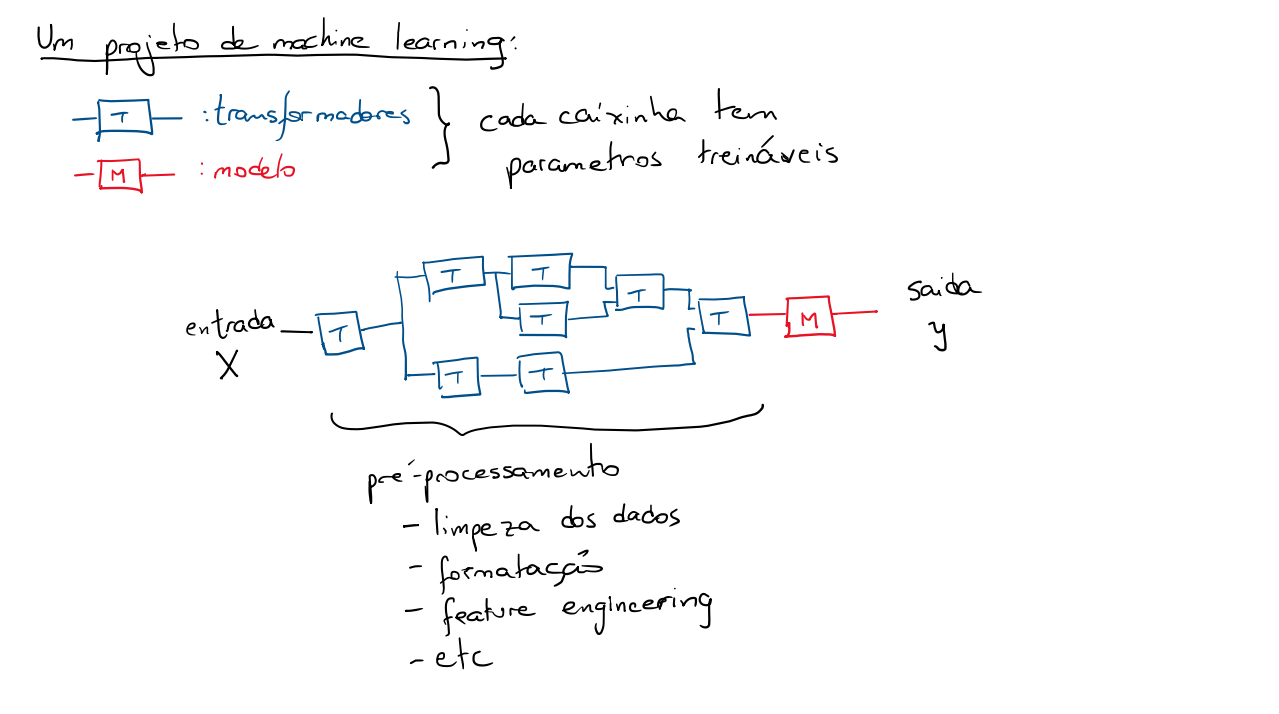

## Dando uma primeira olhada (Análise exploratória)

In [ ]:
df.describe()

**Para um nao numero/categoria**

In [ ]:
df['coluna'].value_counts()

**Histograma**

In [ ]:
df.hist(bins=50)

## Dividindo em treinamento e teste

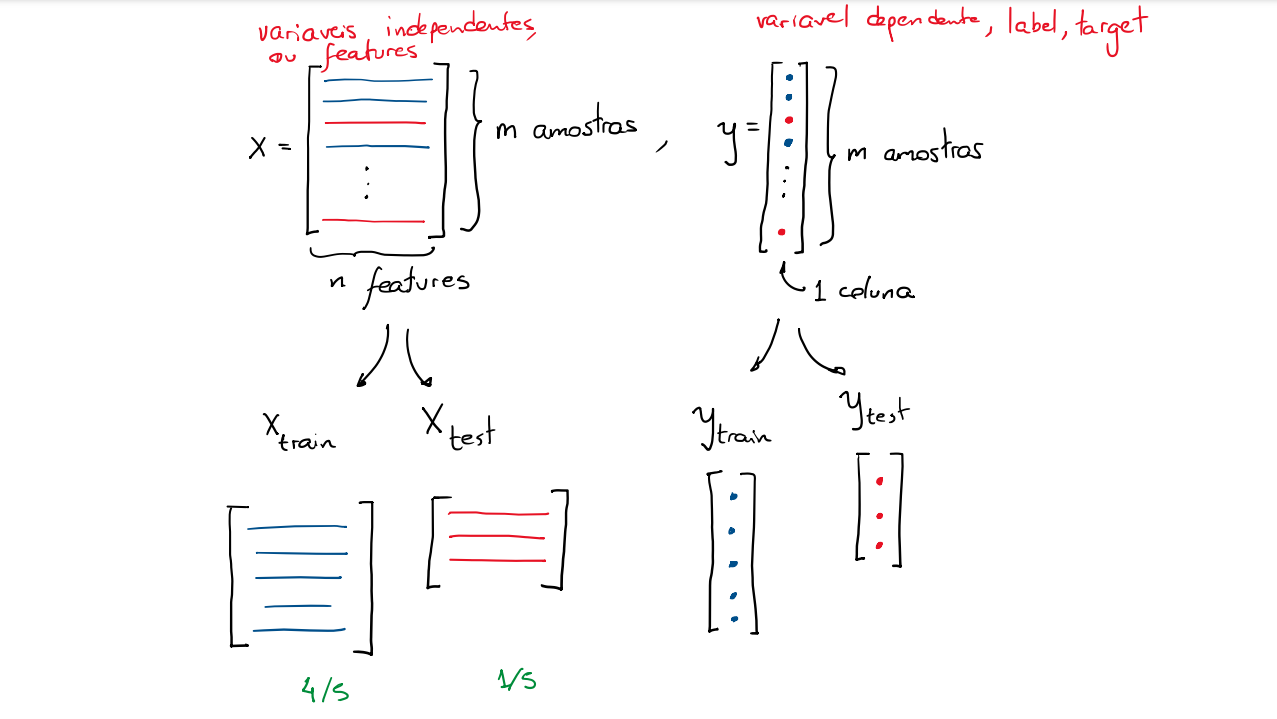

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    housing,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

**Separando em x train e y train**

In [ ]:
X_train = train_set.drop(columns=['median_house_value'])
y_train = train_set['median_house_value']

**Separação estratificada**

In [ ]:
# Constroi uma coluna nova com categorias de renda fictícias.
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True) #Indicando as faixas que vamos querer que seja
                                                                          #Proporcionado

In [ ]:
# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['income_cat'], axis=1, inplace=True)
strat_test_set.drop(['income_cat'], axis=1, inplace=True)

## Correlação

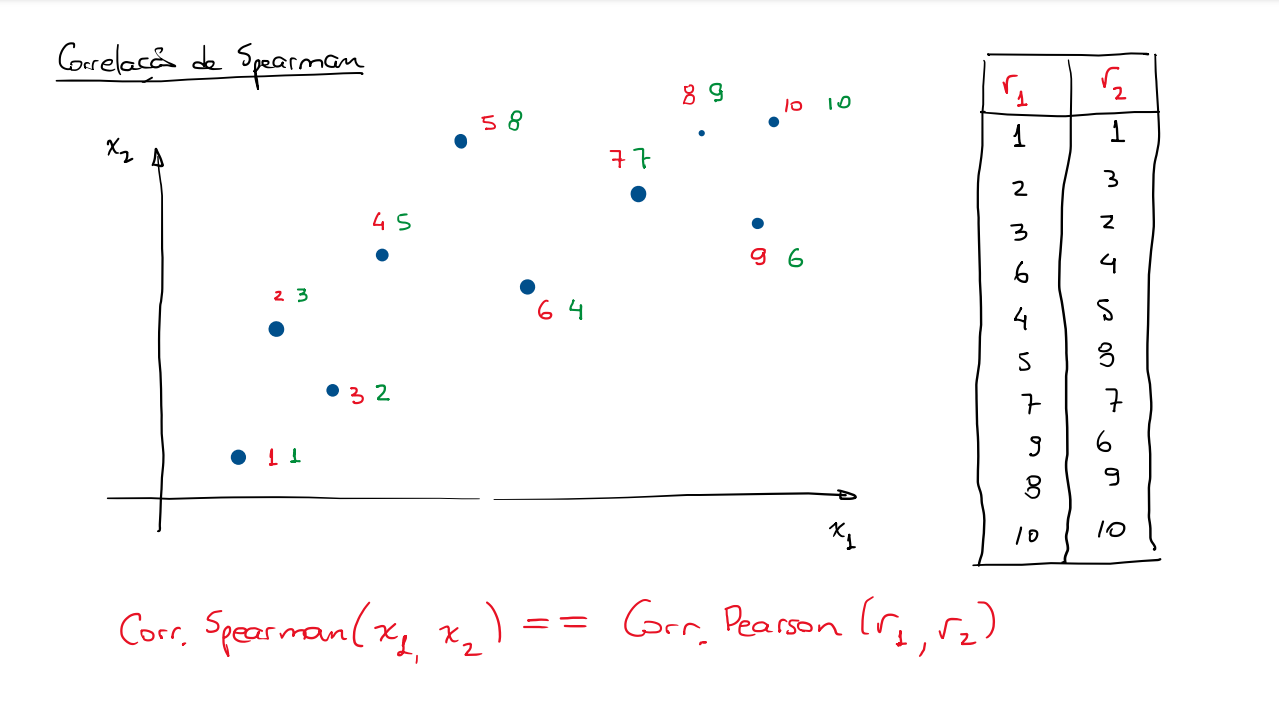

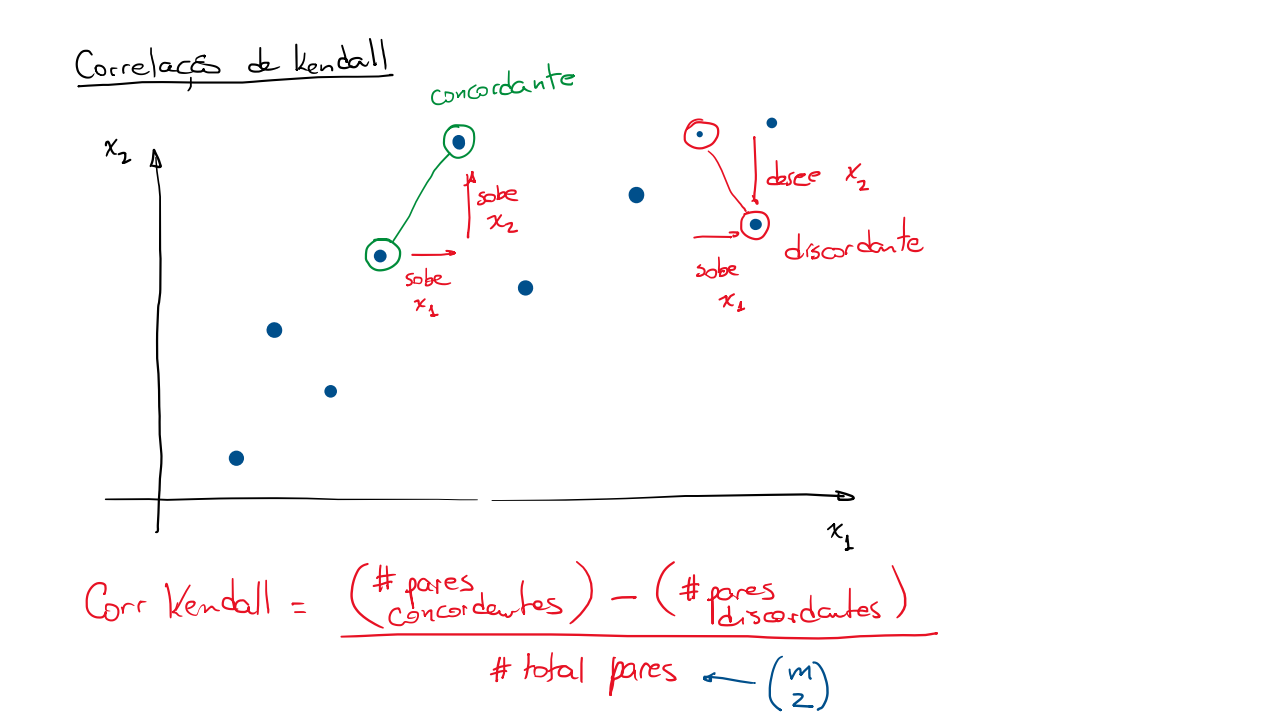

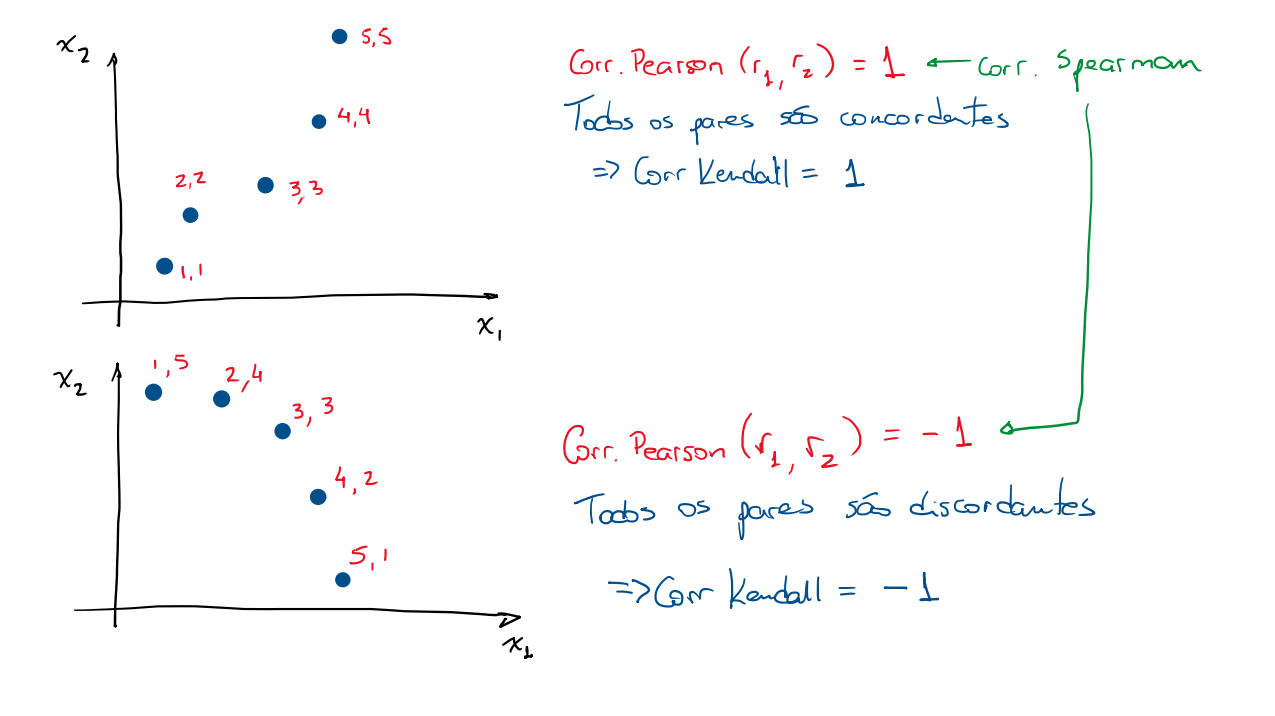

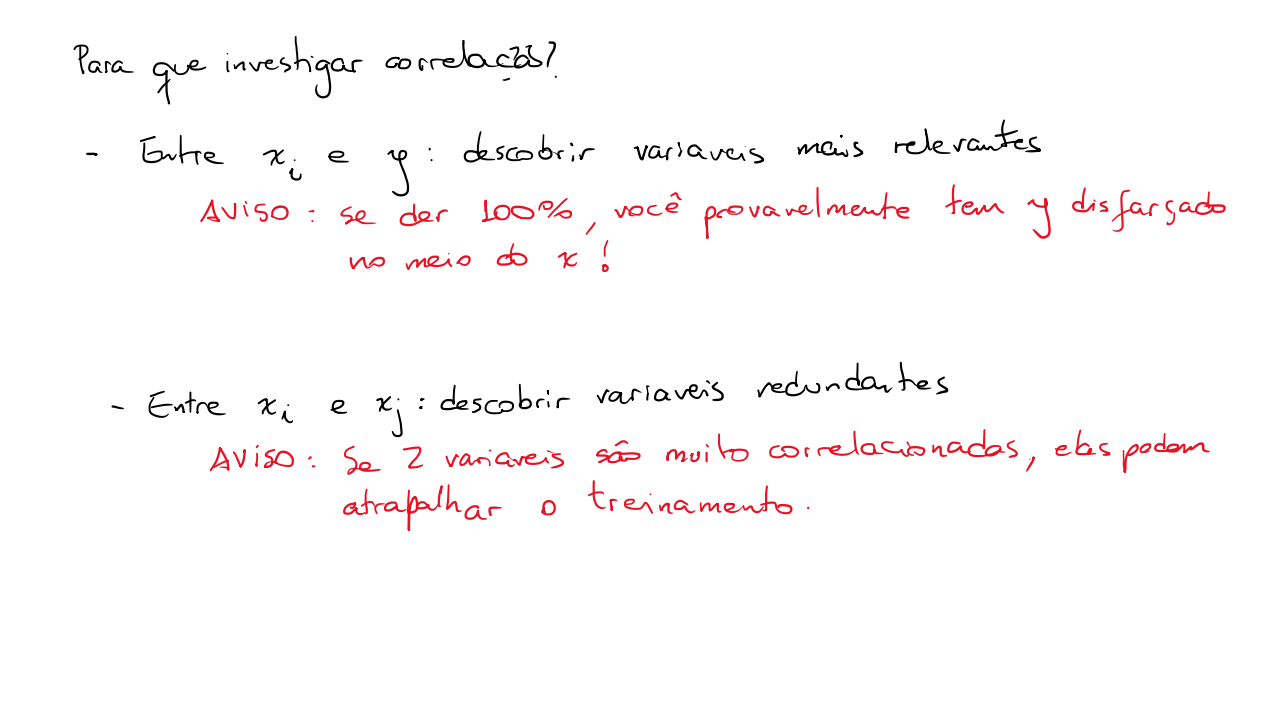

In [ ]:
df.corr() #corr(method='spearman') ou kendall

## Preparando Dados

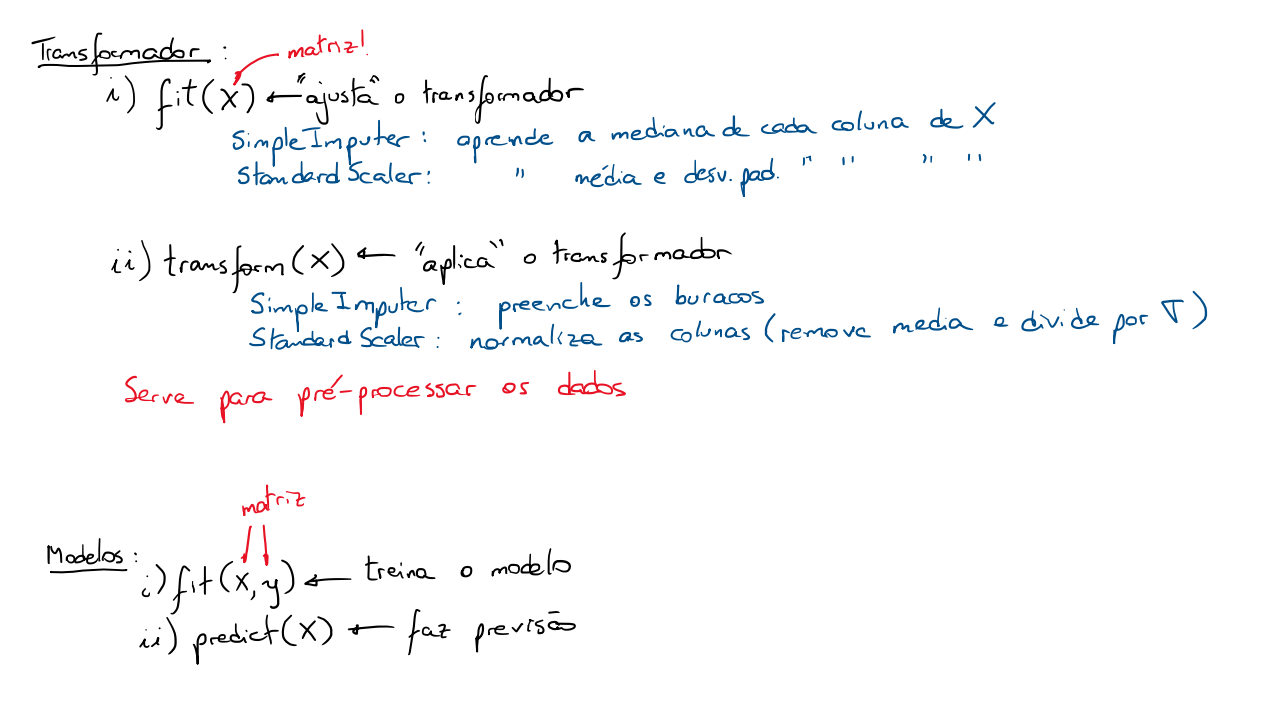

**Vendo NULLS**

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
sample_incomplete_rows

**Tirando NULLS**

In [ ]:
dropLine = df.dropna(0,'any') #0 PARA ROW E 1 PARA COLUNA

**Colocando a Mediana**

In [ ]:
from sklearn.impute import SimpleImputer

# Antes de treinar o SimpleImputer, remover a coluna de dados categóricos. O dataset resultante tem apenas
# as variáveis independentes numéricas.
housing_num = housing.drop('ocean_proximity', axis=1)

# Cria um imputer que substitui células inválidas (NaN) pela mediana dos valores da coluna à qual a célula pertence.
imputer = SimpleImputer(strategy='median')

# Agora treinar o Imputer. Isto vai causar o cálculo da mediana de cada coluna,
# que ficará armazenado no Imputer para uso futuro.
imputer.fit(housing_num)

# O Imputer agora tem as estatísticas desejadas armazenadas.
print('Estatísticas do Imputer:')
print(imputer.statistics_)

# Compare com as medianas do DataFrame:
print('Medianas')
print(housing_num.median().values)

In [ ]:
# Aplicar o Imputer aos nossos dados. O valor de retorno é um ndarray do NumPy.
temp = imputer.transform(housing_num)
print(type(temp))

# Trabalhar com DataFrames geralmente é mais legal - dá para referenciar
# colunas por nome, ao invés de indices. Vamos transformar de volta o ndarray
# em DataFrame.
housing_tr = pd.DataFrame(temp, columns=housing_num.columns)
print(type(housing_tr))

**ONE HOT ENCODER**

In [ ]:
# Cria o codificador.
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')

# Aprende a codificação e já aplica a mesma ao dataset fornecido.
# Todo transformador no sklearn tem os métodos fit() para aprender
# a transformação, e transform() para aplicá-la.
# O método fit_transform() faz os dois atos em sequência.
housing_cat_1hot = encoder.fit_transform(housing_cat)

# O resultado da codificação é uma matriz esparsa em NumPy.
print(housing_cat_1hot)

In [ ]:
# Convertendo em matriz densa só para observar melhor:
print(housing_cat_1hot.toarray()[:5])

# Você poderia também ter usado sparse=False na criação do OneHotEncoder.

encoder.categories_

### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

meu_imputer = SimpleImputer(strategy='median')
meu_adder = CombinedAttributesAdder()
meu_scaler = StandardScaler()

num_pipeline = Pipeline([
    ('imputer', meu_imputer),
    ('attribs_adder', meu_adder),
    ('std_scaler', meu_scaler),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

In [ ]:
meu_one_hot_encoder = OneHotEncoder(sparse=False)

cat_pipeline = Pipeline([
    ('cat_encoder', meu_one_hot_encoder),
])

housing_cat_tr = cat_pipeline.fit_transform(housing_cat)
housing_cat_tr

## Juntando Novas Alterações do DF principal

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) #coluna criada
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),# Antes do FIT
    ('cat', cat_pipeline, cat_attribs),# Antes do FIT
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[:5]

# Aplicando Modelo

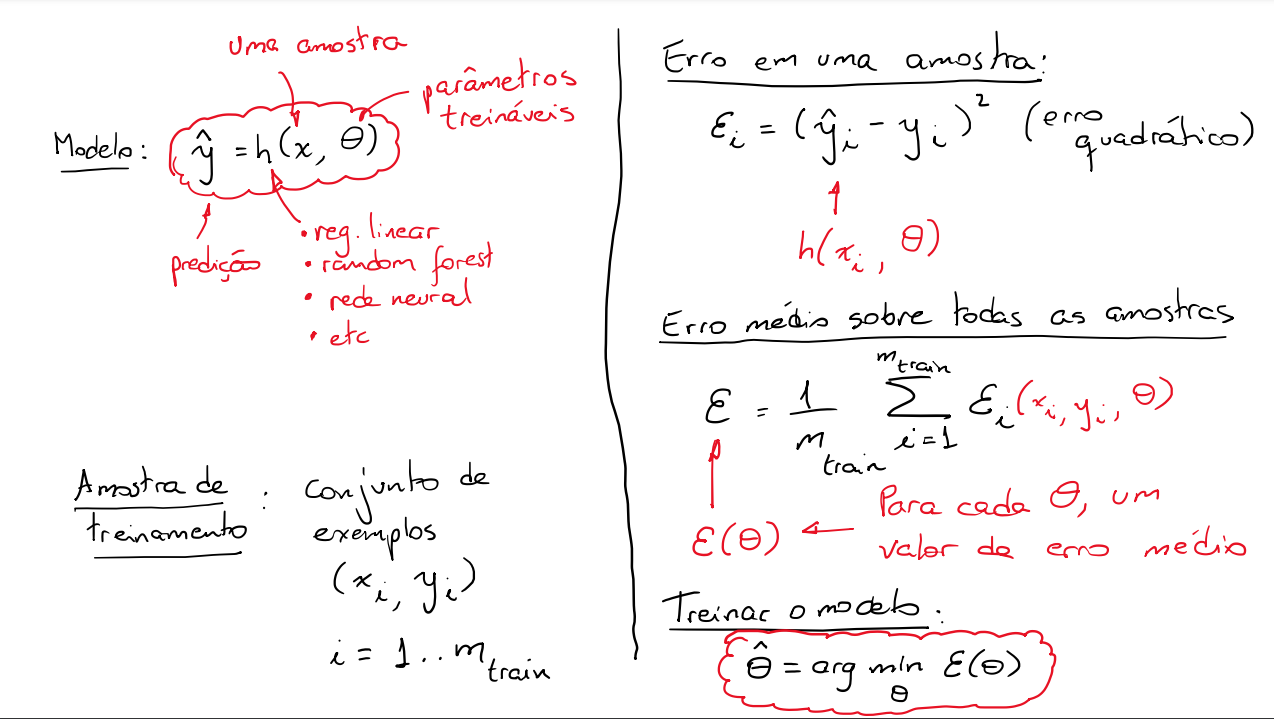

### Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_pipelined, variavel_dependente)#(housing_prepared, housing_labels)

In [ ]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared) #some_data_prepared = uma parte do treinamento
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(some_labels.values.round(decimals=2)))

### Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
predicted_labels = tree_reg.predict(some_data_prepared)
print('Predição: {}'.format(predicted_labels))
print('Original: {}'.format(some_labels.values))

### Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

In [ ]:
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)

# Erro

### Regressão Linear

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

In [ ]:
residuo = housing_labels - housing_predictions

In [ ]:
plt.hist(residuo, bins=50);

### Árvore de Decisão

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Regressão linear: RMSE = {:.2f}'.format(tree_rmse))

### Random Forrest

In [ ]:
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

# Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,  # modelo
    housing_prepared,  # X_train
    housing_labels,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

# Comparando Modelos

In [ ]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Decision Tree': tree_rmse_scores,
    'Random Forest': forest_rmse_scores,
}).plot.box(
    xlabel='Regressor',
    ylabel=r'RMSE $[\mathtt{USD}]$',
    figsize=(6, 4),
);

# Ajuste de Hiperparâmetros

In [ ]:
import time

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2×3) combinations of hyperparameters.
    {
        'n_estimators': [10, 30],
        'max_features': [4, 6, 8],
    },
    # then try 4 (1x2×2) combinations with bootstrap set as False.
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [3, 4],
    },
]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training.
grid_search = GridSearchCV(
    forest_reg,  # Modelo
    param_grid,  # Grid
    cv=5,  # Partições de C.V.
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
)

t1 = time.perf_counter()
grid_search.fit(housing_prepared, housing_labels)
t2 = time.perf_counter()

print(f'Tempo gasto: {t2 - t1:.2f} s')

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

# Importância de Características

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = [
    'rooms_per_hhold',
    'pop_per_hhold',
    'bedrooms_per_room',
]
cat_one_hot_attribs = list(
    cat_pipeline.named_steps['cat_encoder'].categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)